In [43]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
import warnings
warnings.filterwarnings('ignore')

In [32]:
## load dataset
data = tf.keras.utils.image_dataset_from_directory(directory="PlantVillage",
                                                  shuffle=True,
                                                  image_size=(256,256),
                                                  batch_size=32)
data_class = data.class_names
print("Files_Names: ",data_class)
print("-"*100,"\n")

data_scale = data.map(lambda x,y: (x/255,y))
data_batch = data_scale.as_numpy_iterator()
batch = data_batch.next()
for image_batch,labels_batch in data.take(1):
    print("Image Batch: ", image_batch.shape)
    print("Labels_Batch: ", labels_batch.shape)

Found 2152 files belonging to 3 classes.
Files_Names:  ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
---------------------------------------------------------------------------------------------------- 

Image Batch:  (32, 256, 256, 3)
Labels_Batch:  (32,)


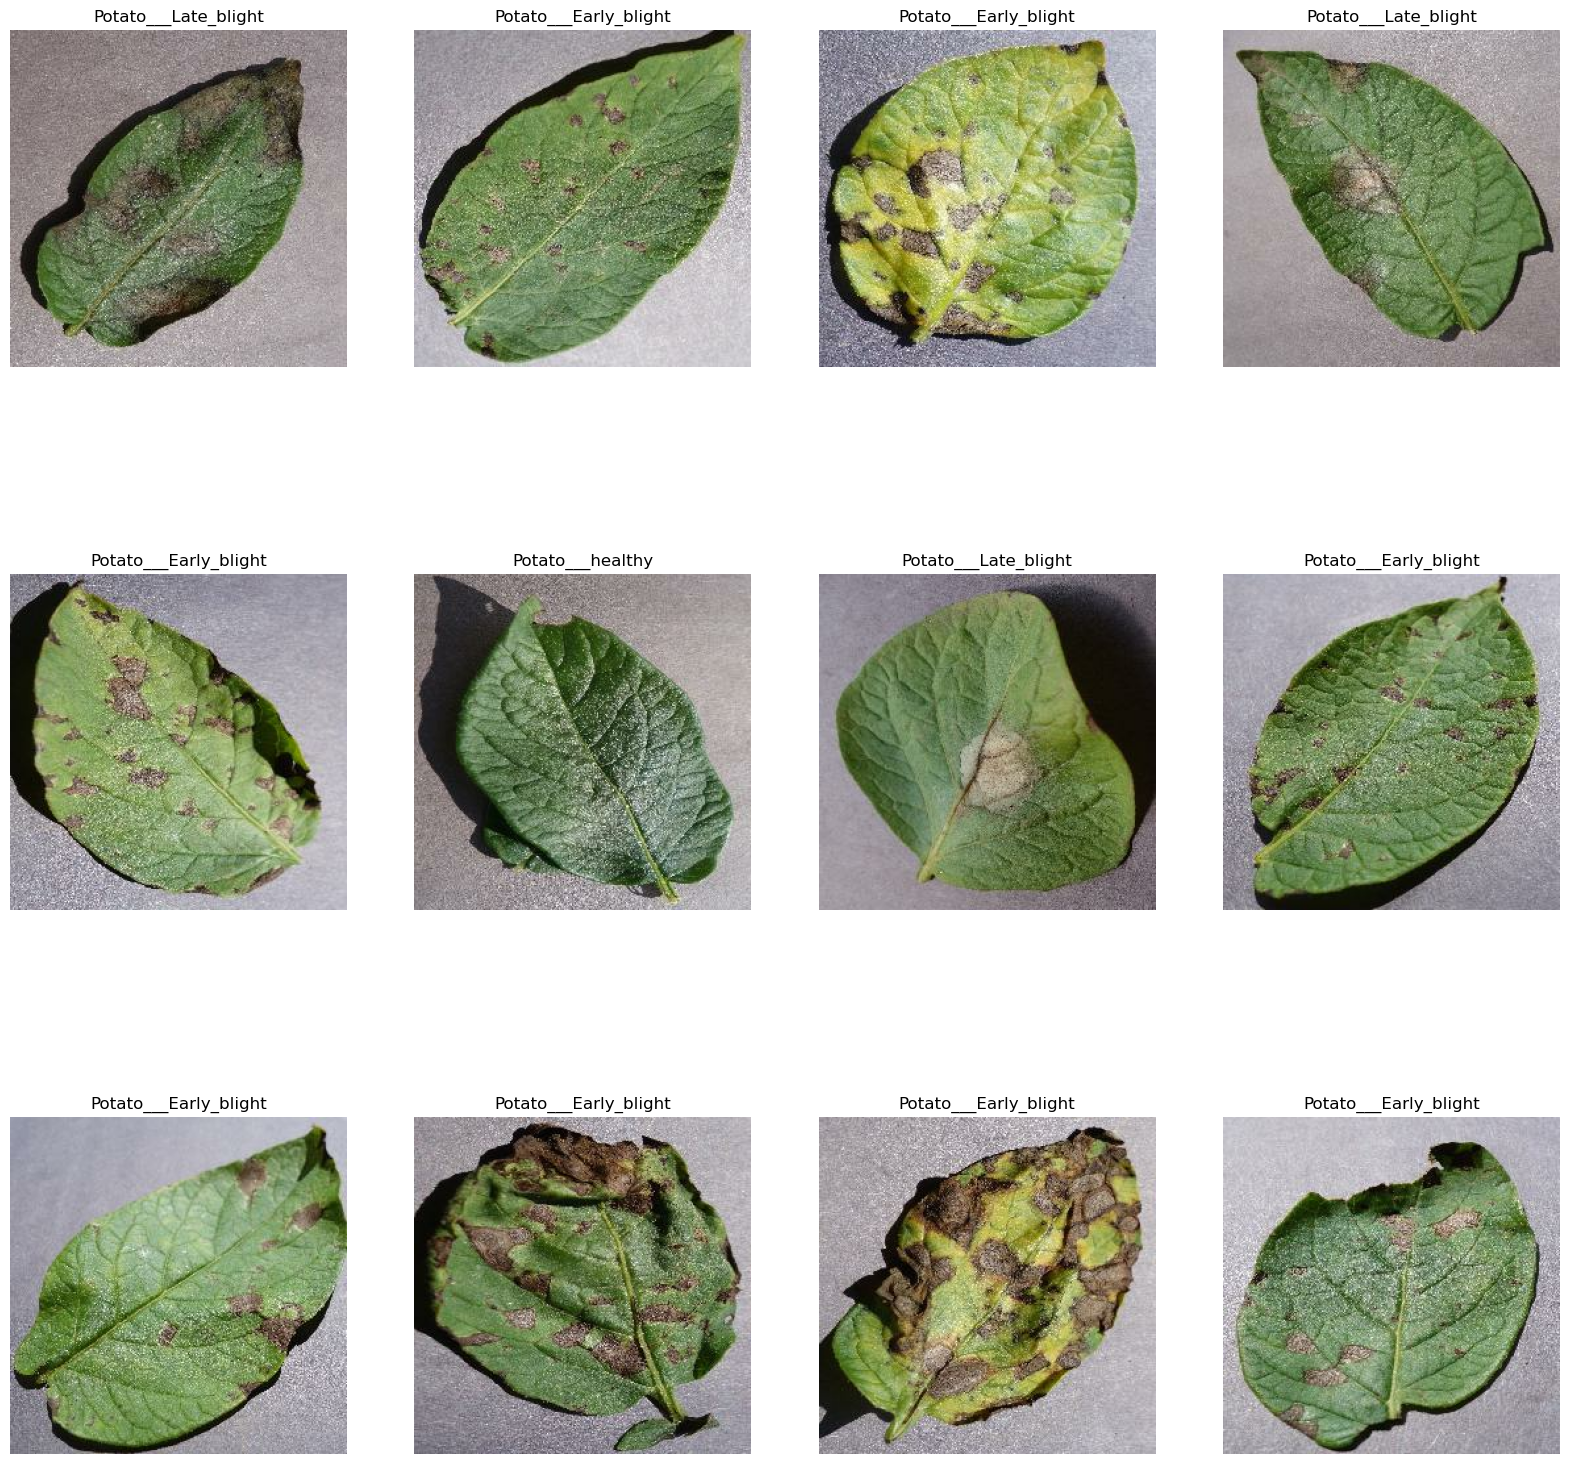

In [33]:
## plot the images
plt.figure(figsize=(20,20))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(data_class[labels_batch[i]])
        plt.axis('off')
plt.show()


### split Train,Validation, Test
- Train 80%
- Validation 10%
- Test 10%

In [34]:
## split 
def dataset(ds, train_size=0.8, test_size=0.1, val_size=0.1, shuffle=True, shuffle_size=10000):
    data = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    train = int(train_size*data)
    val = int(val_size*data)
    train_ds = ds.take(train)
    val_ds = ds.take(val)
    test_ds = ds.skip(train).skip(val)
    return train_ds,test_ds, val_ds

train_ds, test_ds, val_ds = dataset(data)
print("train_size: {0}, val_size: {1}, test_size: {2}".format(len(train_ds), len(val_ds), len(test_ds)))

train_size: 54, val_size: 6, test_size: 8


In [35]:
## were we store image in the memory using cache() and then shuffle image for 1000 times making into faster load using prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
## model building
model = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256,256)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=3, activation='softmax')
    
])

## create batch_size, image_size, channels to show in summary
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model.build(input_shape)

## view model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (32, 256, 256, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (32, 256, 256, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (32, 256, 256, 3)         0         
                                                                 
 random_rotation_1 (RandomR  (32, 256, 256, 3)         0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                 

- Total Parameters inthe model: 183747

In [37]:
## model compile
model.compile(optimizer= tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics=['accuracy'])
## earlystop in model
model_earlystop = EarlyStopping(monitor='val_accuracy',
                                verbose=1,
                                min_delta=0.01,
                                patience=5,
                                mode='auto')

In [38]:
%%time
## model fit 
model_history = model.fit(x=train_ds,
                          epochs=30,
                          verbose=1,
                          validation_data=val_ds,
                          validation_split=0.2,
                          batch_size=32,
                          callbacks=model_earlystop)

Epoch 1/30
54/54 [==============================] - 203s 3s/step - loss: 0.9109 - accuracy: 0.4607 - val_loss: 0.8207 - val_accuracy: 0.5573
Epoch 2/30
54/54 [==============================] - 221s 4s/step - loss: 0.7134 - accuracy: 0.6326 - val_loss: 0.4404 - val_accuracy: 0.8177
Epoch 3/30
54/54 [==============================] - 231s 4s/step - loss: 0.4411 - accuracy: 0.8016 - val_loss: 0.3449 - val_accuracy: 0.8750
Epoch 4/30
54/54 [==============================] - 235s 4s/step - loss: 0.3085 - accuracy: 0.8680 - val_loss: 0.3049 - val_accuracy: 0.9010
Epoch 5/30
54/54 [==============================] - 244s 5s/step - loss: 0.2445 - accuracy: 0.9096 - val_loss: 0.1779 - val_accuracy: 0.9375
Epoch 6/30
54/54 [==============================] - 248s 5s/step - loss: 0.2160 - accuracy: 0.9202 - val_loss: 0.2028 - val_accuracy: 0.9010
Epoch 7/30
54/54 [==============================] - 274s 5s/step - loss: 0.1788 - accuracy: 0.9302 - val_loss: 0.2394 - val_accuracy: 0.9219
Epoch 8/30
54

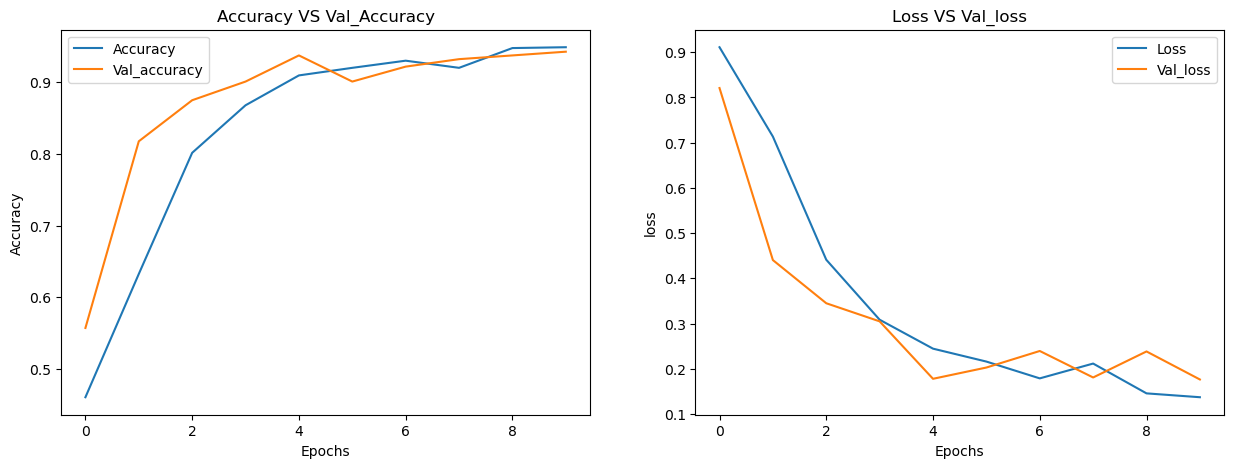

In [40]:
## lets check model is overfit or not looking into plot
accuracy = model_history.history['accuracy']
loss = model_history.history['loss']
val_acc = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_acc, label='Val_accuracy')
plt.title('Accuracy VS Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val_loss')
plt.title('Loss VS Val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [50]:
## predict class in test-set
def predict(model,img):
    img_array = img_to_array(images[i].numpy())
    img_exp = tf.expand_dims(img_array,0) 
    pred = model.predict(img_exp)
    pred_class = data_class[np.argmax(pred[0])]
    confidence = round(100*(np.max(pred[0])),2)
    return pred_class, confidence

1/1 [==============================] - 0s 51ms/step


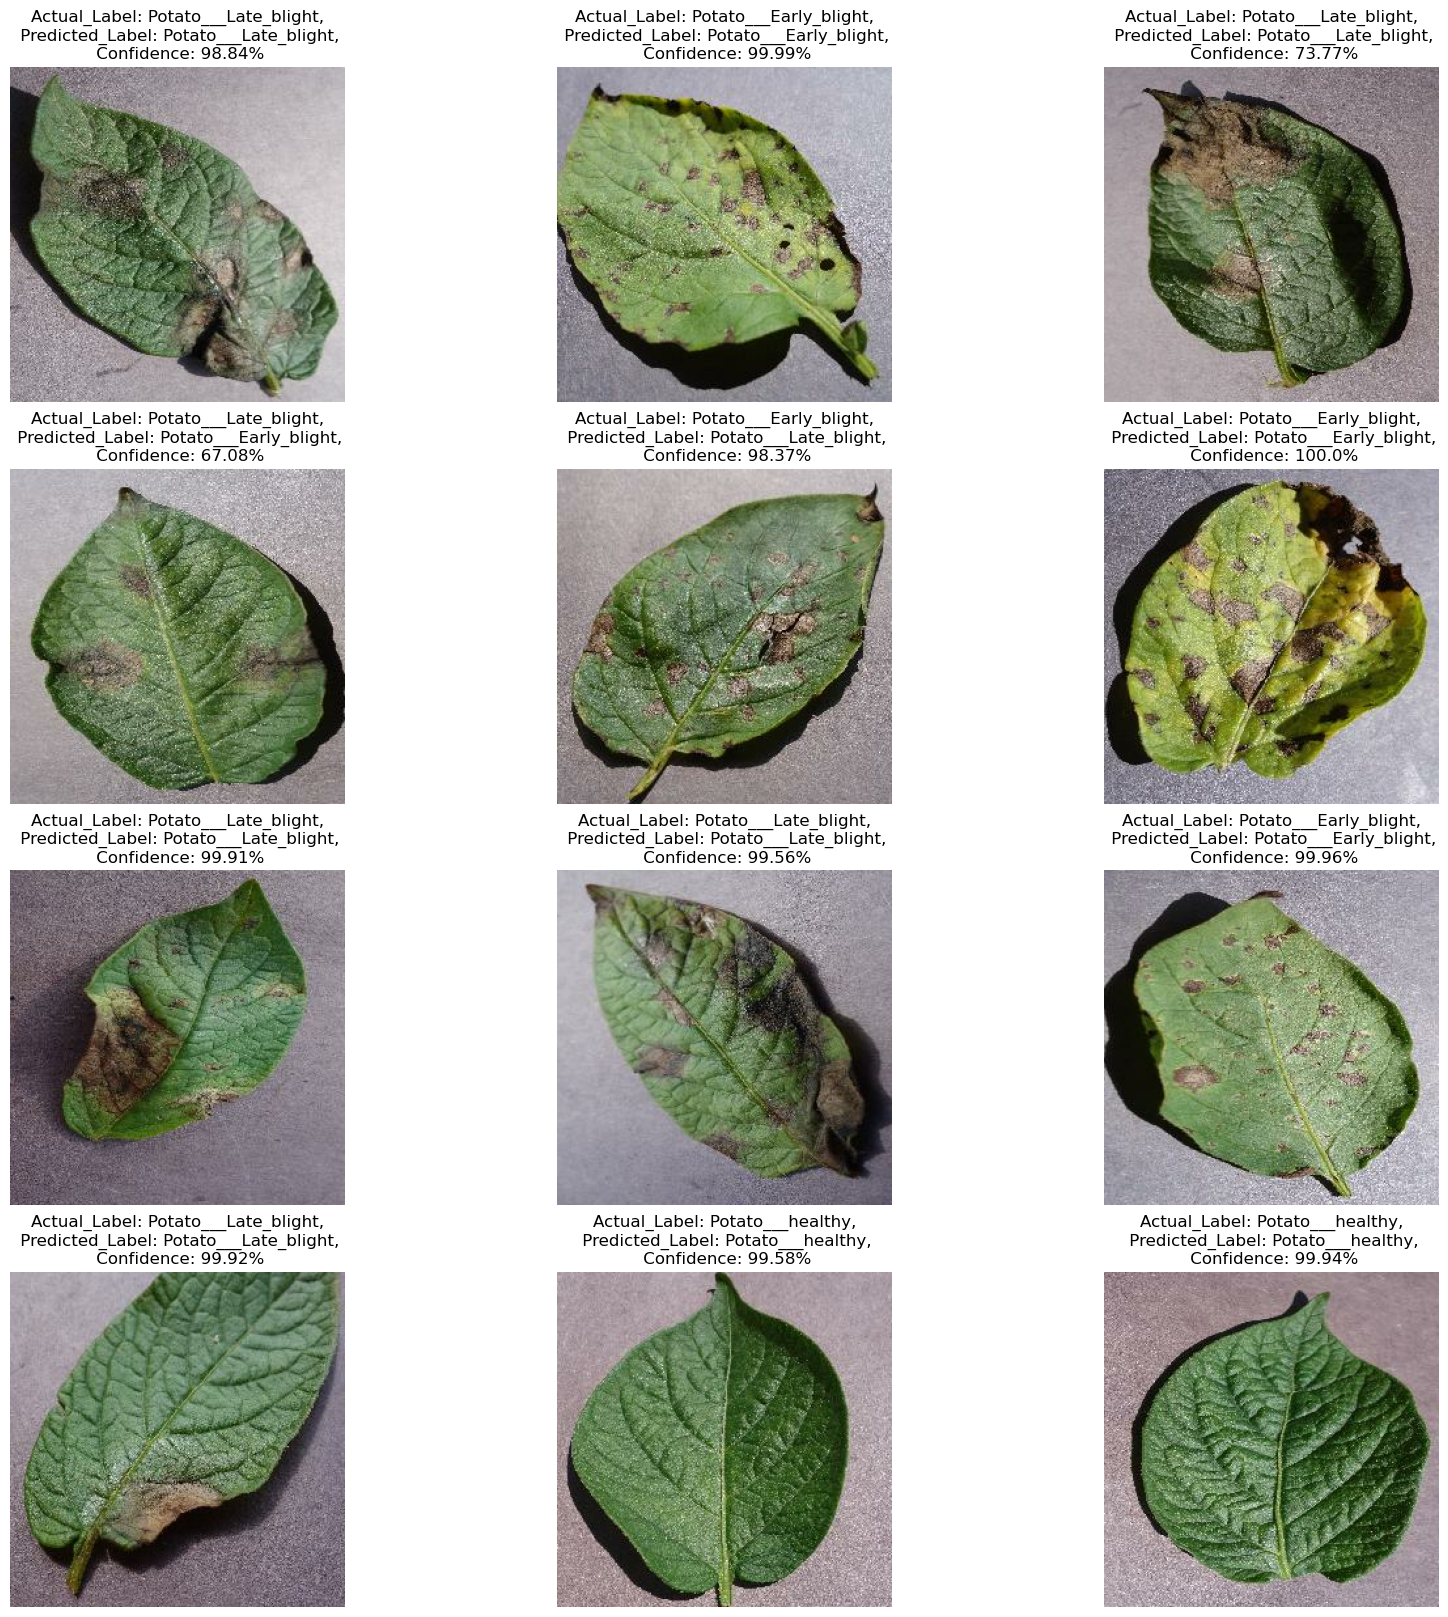

In [57]:
## plot
plt.figure(figsize=(20,20))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(images[i].numpy().astype(int))
        pred_class, confidence = predict(model, images[i].numpy())
        actual_class = data_class[labels[i]]
        plt.title("Actual_Label: {0},\n Predicted_Label: {1},\n Confidence: {2}%".format(actual_class, pred_class, confidence))
        plt.axis('off')
plt.show()

In [58]:
model.save("../Models/")

INFO:tensorflow:Assets written to: ../Models/assets


INFO:tensorflow:Assets written to: ../Models/assets
